In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/My\ Drive/unet/data

/content/gdrive/My Drive/unet/data


In [ ]:
#!pip install albumentations==0.4.6

In [ ]:

import time
import copy

import torch

import pandas as pd

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils


#import tqdm as tqdm
from tqdm import tqdm as tqdm


import cv2

from torch.autograd import Variable
from torch.optim import Adam, SGD
import torch.nn.functional as F
from PIL import Image
from torch import nn
import zipfile

import random

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
TRAIN_PATH = '/content/gdrive/My Drive/unet/data/'

In [ ]:
print(f"Total number of images: {len(os.listdir(os.path.join(TRAIN_PATH, 'images')))}")
print(f"Total number of mask: {len(os.listdir(os.path.join(TRAIN_PATH, 'masks')))}")

Total number of images: 2691
Total number of mask: 2691


In [ ]:
def preprocess_mask(mask):
    #mask = np.array(mask).astype(np.float32)
    mask[mask != 255.0] = 0.0
    mask[mask==255]=1.0
    return mask

def get_train_transform():
   return A.Compose(
       [
        A.Resize(256, 256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HorizontalFlip(p=0.25),
        A.VerticalFlip(p=0.25),
        ToTensor()
        ])

class LoadDataSet(Dataset):
    def __init__(self, path, transform=None):
      #super().__init__()
      self.path = path
      self.images_folder = os.path.join(path, "images")
      self.masks_folder = os.path.join(path, "masks")
      self.transform = transform
      self.images_ids = os.listdir(self.images_folder)
        
    def __getitem__(self, idx):

      image_dir = [self.images_folder+"/"+ids for ids in self.images_ids]
      mask_dir = [self.masks_folder+"/"+ids[:-7]+"mask_buffered.png" for ids in self.images_ids]
      image_name = image_dir[idx]
      mask_name = mask_dir[idx]
      
      img = io.imread(image_name)[:,:,:3].astype('float32')
      mask = io.imread(mask_name).astype('float32')
      mask = preprocess_mask(mask)

      transformed = self.transform(image=img, mask=mask)
      img = transformed['image']
      mask = transformed['mask']
      #img = np.transpose(img, (2,0,1))
      #mask = np.transpose(mask, (2,0,1))

      return img, mask#, image_name

    def __len__(self) -> int:
        return len(self.images_ids)

In [ ]:
train_dataset = LoadDataSet(TRAIN_PATH, transform=get_train_transform())

In [ ]:
image, mask = train_dataset.__getitem__(0)
print(image.shape)
print(mask.shape)

torch.Size([3, 256, 256])
torch.Size([1, 256, 256])


In [ ]:
train_dataset.__len__()

2691

In [ ]:
image

tensor([[[ 0.0698,  0.1768,  0.0783,  ...,  0.8532,  0.6948,  0.6435],
         [ 0.6049,  0.5493, -0.2085,  ...,  1.1486,  1.2086,  0.7676],
         [ 0.5407,  0.6691,  0.1340,  ...,  0.9474,  1.3713,  0.9217],
         ...,
         [ 1.4269,  1.4655,  1.5125,  ...,  0.0655,  0.1212,  0.1811],
         [ 1.4269,  1.4740,  1.5297,  ..., -0.3112, -0.3155, -0.2385],
         [ 1.4911,  1.4697,  1.4226,  ..., -0.5296, -0.5467, -0.3284]],

        [[ 0.1045,  0.2139,  0.1395,  ...,  0.3715,  0.2096,  0.1570],
         [ 0.6078,  0.5509, -0.2237,  ...,  0.6385,  0.6560,  0.2052],
         [ 0.4371,  0.6122,  0.0826,  ...,  0.3540,  0.7610,  0.2927],
         ...,
         [ 1.8683,  1.9077,  1.9559,  ...,  0.0389,  0.0783,  0.1395],
         [ 1.8683,  1.9165,  1.9734,  ..., -0.3113, -0.3332, -0.2500],
         [ 1.9340,  1.9121,  1.8640,  ..., -0.4995, -0.5345, -0.3200]],

        [[-0.9025, -0.7936, -0.8851,  ..., -0.1400, -0.3012, -0.3535],
         [-0.3840, -0.4406, -1.2119,  ...,  0

In [ ]:
mask

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]]])

In [ ]:
def format_image(img):
    img = np.array(np.transpose(img, (1,2,0)))
    mean=np.array((0.485, 0.456, 0.406))
    std=np.array((0.229, 0.224, 0.225))
    img  = std * img + mean
    img = img*255
    img = img.astype(np.uint8)
    return img
def format_mask(mask):
    mask = np.squeeze(np.transpose(mask, (1,2,0)))
    return mask

In [ ]:
def visualize_dataset(n_images, predict=None):
  """
  Function to visualize images and masks
  """
  images = random.sample(range(0, 2691), n_images)
  figure, ax = plt.subplots(nrows=len(images), ncols=2, figsize=(5, 8))
  print(images)
  for i in range(0, len(images)):
    img_no = images[i]
    image, mask = train_dataset.__getitem__(img_no)
    image = format_image(image)
    mask = format_mask(mask)
    ax[i, 0].imshow(image)
    ax[i, 1].imshow(mask, interpolation="nearest", cmap="gray")
    ax[i, 0].set_title("Ground Truth Image")
    ax[i, 1].set_title("Mask")
    ax[i, 0].set_axis_off()
    ax[i, 1].set_axis_off()
  plt.tight_layout()
  plt.show()

[1935, 1545, 1948]


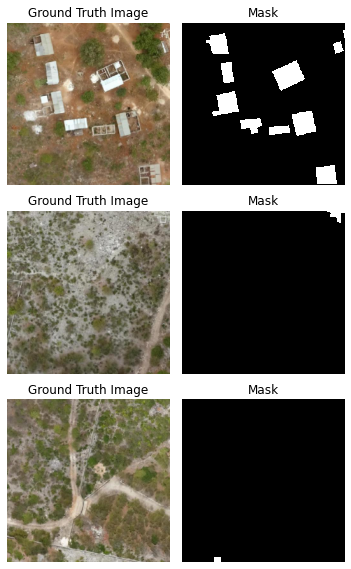

In [ ]:
visualize_dataset(3)

In [ ]:
## Split train and validation set.
train_data, valid_data = random_split(train_dataset, [2000, 691]) #2491, 200

train_loader = DataLoader(dataset=train_data, batch_size=10, shuffle=True)

val_loader = DataLoader(dataset=valid_data, batch_size=10)

In [ ]:
class double_conv(nn.Module):
    '''
    Double Convolution layer with both 2 BN and Activation Layer in between
    Conv2d==>BN==>Activation==>Conv2d==>BN==>Activation
    '''
    def __init__(self, in_channel, out_channel):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channel),
            nn.Conv2d(out_channel, out_channel, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channel)
        )
    def forward(self, x):
        x = self.conv(x)
        return x

class down_conv(nn.Module):
  '''
  A maxpool layer followed by a Double Convolution.
  MaxPool2d==>double_conv.
  '''
  def __init__(self, in_channel, out_channel):
    super(down_conv, self).__init__()
    self.down = nn.Sequential(
        nn.MaxPool2d(2),
        double_conv(in_channel, out_channel)
    )
  def forward(self, x):
    x = self.down(x)
    return x

class up_sample(nn.Module):
  def __init__(self, in_channel, out_channel):
    super(up_sample, self).__init__()
    self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    self.double_conv = double_conv(in_channel, out_channel)

  def forward(self, x1, x2):
      x1 = self.up(x1)
      x = torch.cat([x1, x2], dim=1)
      x = self.double_conv(x)
      return x

class UNet(nn.Module):
  '''Main Unet Model'''
  def __init__(self, in_channel, out_channel):
    super(UNet, self).__init__()
    ## DownSampling Block
    self.down_block1 = double_conv(in_channel, 16)
    self.down_block2 = down_conv(16, 32)
    self.down_block3 = down_conv(32, 64)
    self.down_block4 = down_conv(64, 128)
    self.down_block5 = down_conv(128, 256)
    self.down_block6 = down_conv(256, 512)
    self.down_block7 = down_conv(512, 1024)
    ## UpSampling Block
    self.up_block1 = up_sample(1024+512, 512)
    self.up_block2 = up_sample(512+256, 256)
    self.up_block3 = up_sample(256+128, 128)
    self.up_block4 = up_sample(128+64, 64)
    self.up_block5 = up_sample(64+32, 32)
    self.up_block6 = up_sample(32+16, 16)
    self.up_block7 = nn.Conv2d(16, out_channel, 1)


  def forward(self, x):
    #Down
    x1 = self.down_block1(x)
    x2 = self.down_block2(x1)
    x3 = self.down_block3(x2)
    x4 = self.down_block4(x3)
    x5 = self.down_block5(x4)
    x6 = self.down_block6(x5)
    x7 = self.down_block7(x6)
    #Up
    x8 = self.up_block1(x7, x6)
    x9 = self.up_block2(x8, x5)
    x10 = self.up_block3(x9, x4)
    x11 = self.up_block4(x10, x3)
    x12 = self.up_block5(x11, x2)
    x13 = self.up_block6(x12, x1)
    x14 = self.up_block7(x13)
    out = torch.sigmoid(x14)
    return out

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice


class IoU(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoU, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return IoU

In [ ]:
model = UNet(3,1).cuda()
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-3)

In [ ]:
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

In [ ]:
#from engine import evaluate
criterion = DiceLoss()
accuracy_metric = IoU()
num_epochs=100
valid_loss_min = np.Inf

checkpoint_path = '/content/gdrive/My Drive/unet/data/model_256x_100e/chkpoint_'
best_model_path = '/content/gdrive/My Drive/unet/data/model_256x_100e/bestmodel.pt'

total_train_loss = []
total_train_score = []
total_valid_loss = []
total_valid_score = []

losses_value = 0
for epoch in range(num_epochs):
  
    train_loss = []
    train_score = []
    valid_loss = []
    valid_score = []
    #<-----------Training Loop---------------------------->
    pbar = tqdm(train_loader, desc = 'description')
    for x_train, y_train in pbar:
      x_train = torch.autograd.Variable(x_train).cuda()
      y_train = torch.autograd.Variable(y_train).cuda()
      optimizer.zero_grad()
      output = model(x_train)
      #Loss
      loss = criterion(output, y_train)
      losses_value = loss.item()
      #Score
      score = accuracy_metric(output,y_train)
      loss.backward()
      optimizer.step()
      train_loss.append(losses_value)
      train_score.append(score.item())
      #train_score.append(score)
      pbar.set_description(f"Epoch: {epoch+1}, loss: {losses_value}, IoU: {score}")

    #<---------------Validation Loop---------------------->
    with torch.no_grad():
      for image,mask in val_loader:
        image = torch.autograd.Variable(image).cuda()
        mask = torch.autograd.Variable(mask).cuda()
        output = model(image)
        ## Compute Loss Value.
        loss = criterion(output, mask)
        losses_value = loss.item()
        ## Compute Accuracy Score
        score = accuracy_metric(output,mask)
        valid_loss.append(losses_value)
        valid_score.append(score.item())

    total_train_loss.append(np.mean(train_loss))
    total_train_score.append(np.mean(train_score))
    total_valid_loss.append(np.mean(valid_loss))
    total_valid_score.append(np.mean(valid_score))
    print(f"\n###############Train Loss: {total_train_loss[-1]}, Train IOU: {total_train_score[-1]}###############")
    print(f"###############Valid Loss: {total_valid_loss[-1]}, Valid IOU: {total_valid_score[-1]}###############")

    #Save best model Checkpoint
    # create checkpoint variable and add important data
    checkpoint = {
        'epoch': epoch + 1,
        'valid_loss_min': total_valid_loss[-1],
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    
    # save checkpoint
    save_ckp(checkpoint, False, checkpoint_path, best_model_path)
    
    ## TODO: save the model if validation loss has decreased
    if total_valid_loss[-1] <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,total_valid_loss[-1]))
        # save checkpoint as best model
        save_ckp(checkpoint, True, checkpoint_path, best_model_path)
        valid_loss_min = total_valid_loss[-1]

Epoch: 1, loss: 0.4185677170753479, IoU: 0.4098755121231079: 100%|██████████| 200/200 [58:24<00:00, 17.52s/it]



###############Train Loss: 0.5809333401918412, Train IOU: 0.2734158381074667###############
###############Valid Loss: 0.4662993941988264, Valid IOU: 0.3729159190851663###############
Validation loss decreased (inf --> 0.466299).  Saving model ...


Epoch: 2, loss: 0.19354069232940674, IoU: 0.6756881475448608: 100%|██████████| 200/200 [01:12<00:00,  2.74it/s]



###############Train Loss: 0.3728447464108467, Train IOU: 0.46411218218505385###############
###############Valid Loss: 0.34052324550492424, Valid IOU: 0.5014670137449034###############
Validation loss decreased (0.466299 --> 0.340523).  Saving model ...


Epoch: 3, loss: 0.20536547899246216, IoU: 0.6592491269111633: 100%|██████████| 200/200 [01:12<00:00,  2.75it/s]



###############Train Loss: 0.305576830804348, Train IOU: 0.5377029042690993###############
###############Valid Loss: 0.2928554654121399, Valid IOU: 0.5570991823183639###############
Validation loss decreased (0.340523 --> 0.292855).  Saving model ...


Epoch: 4, loss: 0.3657941222190857, IoU: 0.4643532633781433: 100%|██████████| 200/200 [01:12<00:00,  2.75it/s]



###############Train Loss: 0.2648548036813736, Train IOU: 0.5863595813512802###############
###############Valid Loss: 0.27018804720469886, Valid IOU: 0.5854321036487817###############
Validation loss decreased (0.292855 --> 0.270188).  Saving model ...


Epoch: 5, loss: 0.2396906018257141, IoU: 0.6133086681365967: 100%|██████████| 200/200 [01:12<00:00,  2.76it/s]



###############Train Loss: 0.24813372790813445, Train IOU: 0.6063286092877388###############
###############Valid Loss: 0.2554168164730072, Valid IOU: 0.6045850134188575###############
Validation loss decreased (0.270188 --> 0.255417).  Saving model ...


Epoch: 6, loss: 0.2900168299674988, IoU: 0.5503695011138916: 100%|██████████| 200/200 [01:13<00:00,  2.73it/s]



###############Train Loss: 0.23307452857494354, Train IOU: 0.6268040858209133###############
###############Valid Loss: 0.266899220432554, Valid IOU: 0.5922304537546422###############


Epoch: 7, loss: 0.24272841215133667, IoU: 0.609366774559021: 100%|██████████| 200/200 [01:12<00:00,  2.75it/s]



###############Train Loss: 0.2408404141664505, Train IOU: 0.6173344445228577###############
###############Valid Loss: 0.2615054760660444, Valid IOU: 0.5940098930682455###############


Epoch: 8, loss: 0.1439741849899292, IoU: 0.7482926249504089: 100%|██████████| 200/200 [01:12<00:00,  2.77it/s]



###############Train Loss: 0.2273516982793808, Train IOU: 0.634741687476635###############
###############Valid Loss: 0.2682654057230268, Valid IOU: 0.5879141077000115###############


Epoch: 9, loss: 0.1485229730606079, IoU: 0.7413689494132996: 100%|██████████| 200/200 [01:12<00:00,  2.77it/s]



###############Train Loss: 0.22207786113023759, Train IOU: 0.6425066538900137###############
###############Valid Loss: 0.23428100177219935, Valid IOU: 0.6316623981243797###############
Validation loss decreased (0.255417 --> 0.234281).  Saving model ...


Epoch: 10, loss: 0.13564544916152954, IoU: 0.7611139416694641: 100%|██████████| 200/200 [01:11<00:00,  2.78it/s]



###############Train Loss: 0.21165915161371232, Train IOU: 0.6547524902224541###############
###############Valid Loss: 0.218900419984545, Valid IOU: 0.6510028264086162###############
Validation loss decreased (0.234281 --> 0.218900).  Saving model ...


Epoch: 11, loss: 0.2763022780418396, IoU: 0.5670322775840759: 100%|██████████| 200/200 [01:13<00:00,  2.73it/s]



###############Train Loss: 0.20602126359939577, Train IOU: 0.6634095383435488###############
###############Valid Loss: 0.22050358738218034, Valid IOU: 0.6484487801790237###############


Epoch: 12, loss: 0.15821337699890137, IoU: 0.7267993092536926: 100%|██████████| 200/200 [01:11<00:00,  2.79it/s]



###############Train Loss: 0.20233570247888566, Train IOU: 0.667669635862112###############
###############Valid Loss: 0.21689847878047397, Valid IOU: 0.6534818319603801###############
Validation loss decreased (0.218900 --> 0.216898).  Saving model ...


Epoch: 13, loss: 0.1889057755470276, IoU: 0.6822206974029541: 100%|██████████| 200/200 [01:11<00:00,  2.78it/s]



###############Train Loss: 0.19404389798641206, Train IOU: 0.6788860522210598###############
###############Valid Loss: 0.21755219868251255, Valid IOU: 0.6534246193444623###############


Epoch: 14, loss: 0.22973519563674927, IoU: 0.6263694763183594: 100%|██████████| 200/200 [01:11<00:00,  2.78it/s]



###############Train Loss: 0.19989306956529618, Train IOU: 0.672250135242939###############
###############Valid Loss: 0.21229525123323714, Valid IOU: 0.6602259863567139###############
Validation loss decreased (0.216898 --> 0.212295).  Saving model ...


Epoch: 15, loss: 0.14111441373825073, IoU: 0.752673864364624: 100%|██████████| 200/200 [01:12<00:00,  2.77it/s]



###############Train Loss: 0.20131254732608794, Train IOU: 0.6690563523769378###############
###############Valid Loss: 0.2135107100009918, Valid IOU: 0.6581290187713291###############


Epoch: 16, loss: 0.16216158866882324, IoU: 0.7209331393241882: 100%|██████████| 200/200 [01:11<00:00,  2.79it/s]



###############Train Loss: 0.18835843712091446, Train IOU: 0.6858344350755214###############
###############Valid Loss: 0.2062465386731284, Valid IOU: 0.66942105859385###############
Validation loss decreased (0.212295 --> 0.206247).  Saving model ...


Epoch: 17, loss: 0.21085691452026367, IoU: 0.6517244577407837: 100%|██████████| 200/200 [01:11<00:00,  2.78it/s]



###############Train Loss: 0.1936381381750107, Train IOU: 0.6802867601811886###############
###############Valid Loss: 0.2155111687523978, Valid IOU: 0.6558083873508233###############


Epoch: 18, loss: 0.16867125034332275, IoU: 0.711347222328186: 100%|██████████| 200/200 [01:12<00:00,  2.77it/s]



###############Train Loss: 0.19074805408716203, Train IOU: 0.6839625887572766###############
###############Valid Loss: 0.19974812098911832, Valid IOU: 0.677024522091129###############
Validation loss decreased (0.206247 --> 0.199748).  Saving model ...


Epoch: 19, loss: 0.14868348836898804, IoU: 0.741125762462616: 100%|██████████| 200/200 [01:11<00:00,  2.78it/s]



###############Train Loss: 0.17818619906902314, Train IOU: 0.7002556267380714###############
###############Valid Loss: 0.20371212874140057, Valid IOU: 0.6719841933143991###############


Epoch: 20, loss: 0.19195634126663208, IoU: 0.677916407585144: 100%|██████████| 200/200 [01:12<00:00,  2.77it/s]



###############Train Loss: 0.1828707790374756, Train IOU: 0.6946853065490722###############
###############Valid Loss: 0.20205287677901132, Valid IOU: 0.6749604725678052###############


Epoch: 21, loss: 0.1405765414237976, IoU: 0.7535040378570557: 100%|██████████| 200/200 [01:12<00:00,  2.77it/s]



###############Train Loss: 0.18705208361148834, Train IOU: 0.6887588001787662###############
###############Valid Loss: 0.20178355063710893, Valid IOU: 0.6740339412486979###############


Epoch: 22, loss: 0.17452996969223022, IoU: 0.7028114199638367: 100%|██████████| 200/200 [01:12<00:00,  2.76it/s]



###############Train Loss: 0.1757197591662407, Train IOU: 0.7044095651805401###############
###############Valid Loss: 0.20222384418760028, Valid IOU: 0.6733538674456733###############


Epoch: 23, loss: 0.15600132942199707, IoU: 0.7301036715507507: 100%|██████████| 200/200 [01:11<00:00,  2.79it/s]



###############Train Loss: 0.17217577397823333, Train IOU: 0.7099938079714775###############
###############Valid Loss: 0.20834759048053197, Valid IOU: 0.6654072295874357###############


Epoch: 24, loss: 0.14137452840805054, IoU: 0.7522748112678528: 100%|██████████| 200/200 [01:11<00:00,  2.79it/s]



###############Train Loss: 0.17284551829099656, Train IOU: 0.7086708278954029###############
###############Valid Loss: 0.1942142537661961, Valid IOU: 0.6846146687333073###############
Validation loss decreased (0.199748 --> 0.194214).  Saving model ...


Epoch: 25, loss: 0.15513598918914795, IoU: 0.7313989996910095: 100%|██████████| 200/200 [01:12<00:00,  2.76it/s]



###############Train Loss: 0.177947938144207, Train IOU: 0.7012608751654625###############
###############Valid Loss: 0.19903984325272697, Valid IOU: 0.6778629204391369###############


Epoch: 26, loss: 0.17571115493774414, IoU: 0.7011004090309143: 100%|██████████| 200/200 [01:11<00:00,  2.80it/s]



###############Train Loss: 0.18042492002248764, Train IOU: 0.6977994330227375###############
###############Valid Loss: 0.21375935673713684, Valid IOU: 0.6582165719924628###############


Epoch: 27, loss: 0.1190481185913086, IoU: 0.7872346639633179: 100%|██████████| 200/200 [01:11<00:00,  2.81it/s]



###############Train Loss: 0.17265962392091752, Train IOU: 0.7089047886431217###############
###############Valid Loss: 0.18442446504320417, Valid IOU: 0.6990221655908889###############
Validation loss decreased (0.194214 --> 0.184424).  Saving model ...


Epoch: 28, loss: 0.14659172296524048, IoU: 0.7443029284477234: 100%|██████████| 200/200 [01:11<00:00,  2.80it/s]



###############Train Loss: 0.1692327442765236, Train IOU: 0.7136940230429173###############
###############Valid Loss: 0.19069210290908814, Valid IOU: 0.6893498965539038###############


Epoch: 29, loss: 0.15408676862716675, IoU: 0.7329732775688171: 100%|██████████| 200/200 [01:11<00:00,  2.79it/s]



###############Train Loss: 0.16618377298116685, Train IOU: 0.7187406204640865###############
###############Valid Loss: 0.20449358906064716, Valid IOU: 0.6710446970005121###############


Epoch: 30, loss: 0.12220102548599243, IoU: 0.7822127342224121: 100%|██████████| 200/200 [01:11<00:00,  2.79it/s]



###############Train Loss: 0.16639689952135087, Train IOU: 0.7168512496352196###############
###############Valid Loss: 0.18094858867781502, Valid IOU: 0.7035915434959211###############
Validation loss decreased (0.184424 --> 0.180949).  Saving model ...


Epoch: 31, loss: 0.1386420726776123, IoU: 0.7564808130264282: 100%|██████████| 200/200 [01:12<00:00,  2.77it/s]



###############Train Loss: 0.16633009284734726, Train IOU: 0.7179541328549385###############
###############Valid Loss: 0.1862359779221671, Valid IOU: 0.6955161397079271###############


Epoch: 32, loss: 0.27549970149993896, IoU: 0.5680168271064758: 100%|██████████| 200/200 [01:12<00:00,  2.76it/s]



###############Train Loss: 0.1641357907652855, Train IOU: 0.7217412528395653###############
###############Valid Loss: 0.20720715948513577, Valid IOU: 0.6668125387680318###############


Epoch: 33, loss: 0.15732640027999878, IoU: 0.7281229496002197: 100%|██████████| 200/200 [01:12<00:00,  2.78it/s]



###############Train Loss: 0.16610948383808136, Train IOU: 0.7183459758758545###############
###############Valid Loss: 0.18964762261935642, Valid IOU: 0.691318489810718###############


Epoch: 34, loss: 0.11088013648986816, IoU: 0.8003758788108826: 100%|██████████| 200/200 [01:11<00:00,  2.79it/s]



###############Train Loss: 0.16655506402254106, Train IOU: 0.7177937664091587###############
###############Valid Loss: 0.19150368911879403, Valid IOU: 0.689203424126442###############


Epoch: 35, loss: 0.22856265306472778, IoU: 0.6279211640357971: 100%|██████████| 200/200 [01:11<00:00,  2.78it/s]



###############Train Loss: 0.17453828185796738, Train IOU: 0.7075149571895599###############
###############Valid Loss: 0.19743188108716692, Valid IOU: 0.680218161589333###############


Epoch: 36, loss: 0.15521478652954102, IoU: 0.7312823534011841: 100%|██████████| 200/200 [01:12<00:00,  2.77it/s]



###############Train Loss: 0.16188598692417144, Train IOU: 0.723904644548893###############
###############Valid Loss: 0.1829180198056357, Valid IOU: 0.7006466140771018###############


Epoch: 37, loss: 0.14854216575622559, IoU: 0.7413395047187805: 100%|██████████| 200/200 [01:11<00:00,  2.78it/s]



###############Train Loss: 0.16243367463350297, Train IOU: 0.723442811369896###############
###############Valid Loss: 0.1816492089203426, Valid IOU: 0.7020955317121531###############


Epoch: 38, loss: 0.1209074854850769, IoU: 0.784270703792572: 100%|██████████| 200/200 [01:11<00:00,  2.79it/s]



###############Train Loss: 0.15978553563356399, Train IOU: 0.7275560799241066###############
###############Valid Loss: 0.18506608520235335, Valid IOU: 0.6973518725750701###############


Epoch: 39, loss: 0.13081753253936768, IoU: 0.7686341404914856: 100%|██████████| 200/200 [01:11<00:00,  2.78it/s]



###############Train Loss: 0.1635917091369629, Train IOU: 0.7217098867893219###############
###############Valid Loss: 0.18794652223587036, Valid IOU: 0.6931712262864623###############


Epoch: 40, loss: 0.17284506559371948, IoU: 0.705256998538971: 100%|██████████| 200/200 [01:11<00:00,  2.79it/s]



###############Train Loss: 0.15205255776643753, Train IOU: 0.7383544608950615###############
###############Valid Loss: 0.18521238139697482, Valid IOU: 0.6976482102248286###############


Epoch: 41, loss: 0.14520752429962158, IoU: 0.7464100122451782: 100%|██████████| 200/200 [01:11<00:00,  2.81it/s]



###############Train Loss: 0.15340545564889907, Train IOU: 0.7368993186950683###############
###############Valid Loss: 0.18374138815062388, Valid IOU: 0.6997662678427462###############


Epoch: 42, loss: 0.15737158060073853, IoU: 0.7280563712120056: 100%|██████████| 200/200 [01:11<00:00,  2.78it/s]



###############Train Loss: 0.15429116010665894, Train IOU: 0.7361551335453987###############
###############Valid Loss: 0.1933499276638031, Valid IOU: 0.6858594395818987###############


Epoch: 43, loss: 0.12454831600189209, IoU: 0.7784937024116516: 100%|██████████| 200/200 [01:12<00:00,  2.77it/s]



###############Train Loss: 0.16413043230772018, Train IOU: 0.7217532753944397###############
###############Valid Loss: 0.19188959428242275, Valid IOU: 0.6882719161654157###############


Epoch: 44, loss: 0.141740620136261, IoU: 0.7517136335372925: 100%|██████████| 200/200 [01:11<00:00,  2.78it/s]



###############Train Loss: 0.1642983675003052, Train IOU: 0.7220027578622102###############
###############Valid Loss: 0.18331417526517596, Valid IOU: 0.6997179550650928###############


Epoch: 45, loss: 0.1057356595993042, IoU: 0.8087520003318787: 100%|██████████| 200/200 [01:11<00:00,  2.78it/s]



###############Train Loss: 0.15460385382175446, Train IOU: 0.7352787590026856###############
###############Valid Loss: 0.18386000650269643, Valid IOU: 0.6999450618866832###############


Epoch: 46, loss: 0.1486912965774536, IoU: 0.7411138415336609: 100%|██████████| 200/200 [01:12<00:00,  2.77it/s]



###############Train Loss: 0.15007750064134598, Train IOU: 0.7413292860984803###############
###############Valid Loss: 0.17888337458883014, Valid IOU: 0.7068433151048209###############
Validation loss decreased (0.180949 --> 0.178883).  Saving model ...


Epoch: 47, loss: 0.22625839710235596, IoU: 0.630982518196106: 100%|██████████| 200/200 [01:11<00:00,  2.79it/s]



###############Train Loss: 0.16070706516504288, Train IOU: 0.7262099432945252###############
###############Valid Loss: 0.18728925159999302, Valid IOU: 0.6949782742586519###############


Epoch: 48, loss: 0.1369115710258484, IoU: 0.759152889251709: 100%|██████████| 200/200 [01:11<00:00,  2.79it/s]



###############Train Loss: 0.15368919044733048, Train IOU: 0.7367938314378262###############
###############Valid Loss: 0.1764888150351388, Valid IOU: 0.7097523456971561###############
Validation loss decreased (0.178883 --> 0.176489).  Saving model ...


Epoch: 49, loss: 0.14072376489639282, IoU: 0.7532745003700256: 100%|██████████| 200/200 [01:12<00:00,  2.76it/s]



###############Train Loss: 0.15543730169534684, Train IOU: 0.7341233575344086###############
###############Valid Loss: 0.17480816074780056, Valid IOU: 0.7121873265132308###############
Validation loss decreased (0.176489 --> 0.174808).  Saving model ...


Epoch: 50, loss: 0.15502279996871948, IoU: 0.7315687537193298: 100%|██████████| 200/200 [01:12<00:00,  2.78it/s]



###############Train Loss: 0.16292912036180496, Train IOU: 0.7229630810022354###############
###############Valid Loss: 0.17880665234157017, Valid IOU: 0.7063871019120728###############


Epoch: 51, loss: 0.1642841100692749, IoU: 0.7177983522415161: 100%|██████████| 200/200 [01:11<00:00,  2.80it/s]



###############Train Loss: 0.1530362695455551, Train IOU: 0.737823876440525###############
###############Valid Loss: 0.1752270119530814, Valid IOU: 0.7113205362643514###############


Epoch: 52, loss: 0.13510406017303467, IoU: 0.7619553208351135: 100%|██████████| 200/200 [01:11<00:00,  2.78it/s]



###############Train Loss: 0.14796872496604918, Train IOU: 0.7446661692857742###############
###############Valid Loss: 0.19254394343921116, Valid IOU: 0.6868916350416839###############


Epoch: 53, loss: 0.3532698154449463, IoU: 0.47790899872779846: 100%|██████████| 200/200 [01:12<00:00,  2.77it/s]



###############Train Loss: 0.15251732677221297, Train IOU: 0.738719180971384###############
###############Valid Loss: 0.17513212135859899, Valid IOU: 0.7113382960004466###############


Epoch: 54, loss: 0.149213969707489, IoU: 0.740321159362793: 100%|██████████| 200/200 [01:12<00:00,  2.77it/s]



###############Train Loss: 0.1486326915025711, Train IOU: 0.7444276617467404###############
###############Valid Loss: 0.1833538396017892, Valid IOU: 0.6996315791803811###############


Epoch: 55, loss: 0.2636305093765259, IoU: 0.5827444195747375: 100%|██████████| 200/200 [01:12<00:00,  2.76it/s]



###############Train Loss: 0.15231147825717925, Train IOU: 0.7380504432320595###############
###############Valid Loss: 0.17681980218206134, Valid IOU: 0.7091319396160543###############


Epoch: 56, loss: 0.15876394510269165, IoU: 0.7259788513183594: 100%|██████████| 200/200 [01:12<00:00,  2.76it/s]



###############Train Loss: 0.14784930408000946, Train IOU: 0.7448979952931404###############
###############Valid Loss: 0.17194447432245527, Valid IOU: 0.7161101507289069###############
Validation loss decreased (0.174808 --> 0.171944).  Saving model ...


Epoch: 57, loss: 0.1283363699913025, IoU: 0.7725223898887634: 100%|██████████| 200/200 [01:13<00:00,  2.74it/s]



###############Train Loss: 0.1463169890642166, Train IOU: 0.7475240284204483###############
###############Valid Loss: 0.17613164186477662, Valid IOU: 0.7104405875583845###############


Epoch: 58, loss: 0.21561086177825928, IoU: 0.6452670693397522: 100%|██████████| 200/200 [01:12<00:00,  2.77it/s]



###############Train Loss: 0.144080972969532, Train IOU: 0.7504603254795075###############
###############Valid Loss: 0.17509277037211826, Valid IOU: 0.7124854614425983###############


Epoch: 59, loss: 0.12273019552230835, IoU: 0.7813735604286194: 100%|██████████| 200/200 [01:12<00:00,  2.78it/s]



###############Train Loss: 0.14291644394397734, Train IOU: 0.7528882530331612###############
###############Valid Loss: 0.173855311529977, Valid IOU: 0.7140343307118331###############


Epoch: 60, loss: 0.11865979433059692, IoU: 0.7878544926643372: 100%|██████████| 200/200 [01:12<00:00,  2.76it/s]



###############Train Loss: 0.1428740492463112, Train IOU: 0.7520643797516823###############
###############Valid Loss: 0.17474780423300607, Valid IOU: 0.7121423622460238###############


Epoch: 61, loss: 0.11629122495651245, IoU: 0.7916483879089355: 100%|██████████| 200/200 [01:12<00:00,  2.77it/s]



###############Train Loss: 0.14530641704797745, Train IOU: 0.7488527697324753###############
###############Valid Loss: 0.18157480444226945, Valid IOU: 0.7051505439515625###############


Epoch: 62, loss: 0.12510240077972412, IoU: 0.777617871761322: 100%|██████████| 200/200 [01:12<00:00,  2.78it/s]



###############Train Loss: 0.14406509965658187, Train IOU: 0.7511018401384354###############
###############Valid Loss: 0.18582483189446586, Valid IOU: 0.6962151086756161###############


Epoch: 63, loss: 0.223005473613739, IoU: 0.6353173851966858: 100%|██████████| 200/200 [01:12<00:00,  2.77it/s]



###############Train Loss: 0.14427359014749527, Train IOU: 0.7506034733355045###############
###############Valid Loss: 0.17950723682131087, Valid IOU: 0.7052736285009554###############


Epoch: 64, loss: 0.16348451375961304, IoU: 0.7189769744873047: 100%|██████████| 200/200 [01:12<00:00,  2.77it/s]



###############Train Loss: 0.14277878075838088, Train IOU: 0.7529736769199371###############
###############Valid Loss: 0.17288817422730582, Valid IOU: 0.7148483616566019###############


Epoch: 65, loss: 0.12814879417419434, IoU: 0.7728180289268494: 100%|██████████| 200/200 [01:11<00:00,  2.79it/s]



###############Train Loss: 0.13906028717756272, Train IOU: 0.7579806700348855###############
###############Valid Loss: 0.17681097047669547, Valid IOU: 0.709724676449384###############


Epoch: 66, loss: 0.14632219076156616, IoU: 0.7447124123573303: 100%|██████████| 200/200 [01:11<00:00,  2.78it/s]



###############Train Loss: 0.13805010437965393, Train IOU: 0.7596913331747055###############
###############Valid Loss: 0.1753883080823081, Valid IOU: 0.7112228262903435###############


Epoch: 67, loss: 0.11878865957260132, IoU: 0.7876514792442322: 100%|██████████| 200/200 [01:11<00:00,  2.79it/s]



###############Train Loss: 0.13839494854211806, Train IOU: 0.7592973464727402###############
###############Valid Loss: 0.17153909376689366, Valid IOU: 0.7174238816968033###############
Validation loss decreased (0.171944 --> 0.171539).  Saving model ...


Epoch: 68, loss: 0.1430199146270752, IoU: 0.7497522234916687: 100%|██████████| 200/200 [01:11<00:00,  2.79it/s]



###############Train Loss: 0.14428985238075256, Train IOU: 0.7511506602168083###############
###############Valid Loss: 0.17680579679352895, Valid IOU: 0.7089679627546243###############


Epoch: 69, loss: 0.09805768728256226, IoU: 0.8213990926742554: 100%|██████████| 200/200 [01:11<00:00,  2.80it/s]



###############Train Loss: 0.14392393410205842, Train IOU: 0.751882621794939###############
###############Valid Loss: 0.17254220076969692, Valid IOU: 0.7152388309394675###############


Epoch: 70, loss: 0.10735028982162476, IoU: 0.8061146140098572: 100%|██████████| 200/200 [01:11<00:00,  2.82it/s]



###############Train Loss: 0.14126614809036256, Train IOU: 0.755828273743391###############
###############Valid Loss: 0.17317685229437693, Valid IOU: 0.7142680102027953###############


Epoch: 71, loss: 0.1784895658493042, IoU: 0.697089672088623: 100%|██████████| 200/200 [01:11<00:00,  2.78it/s]



###############Train Loss: 0.13770966678857804, Train IOU: 0.7603851872682571###############
###############Valid Loss: 0.16922714539936612, Valid IOU: 0.7202709582301655###############
Validation loss decreased (0.171539 --> 0.169227).  Saving model ...


Epoch: 72, loss: 0.0971837043762207, IoU: 0.822850227355957: 100%|██████████| 200/200 [01:11<00:00,  2.78it/s]



###############Train Loss: 0.13647547990083694, Train IOU: 0.7621355111896991###############
###############Valid Loss: 0.16994018128940036, Valid IOU: 0.7193563892705632###############


Epoch: 73, loss: 0.1772221326828003, IoU: 0.6989207863807678: 100%|██████████| 200/200 [01:11<00:00,  2.79it/s]



###############Train Loss: 0.14230291664600372, Train IOU: 0.7537472677230835###############
###############Valid Loss: 0.1700992030756814, Valid IOU: 0.7189835920131632###############


Epoch: 74, loss: 0.12733596563339233, IoU: 0.7740952968597412: 100%|██████████| 200/200 [01:11<00:00,  2.81it/s]



###############Train Loss: 0.13853192895650865, Train IOU: 0.7594197545945645###############
###############Valid Loss: 0.18922867264066423, Valid IOU: 0.6916407989604133###############


Epoch: 75, loss: 0.1890307068824768, IoU: 0.682044506072998: 100%|██████████| 200/200 [01:11<00:00,  2.80it/s]



###############Train Loss: 0.14107791423797608, Train IOU: 0.7555461223423481###############
###############Valid Loss: 0.1715777133192335, Valid IOU: 0.7170924339709538###############


Epoch: 76, loss: 0.14054393768310547, IoU: 0.7535524368286133: 100%|██████████| 200/200 [01:11<00:00,  2.81it/s]



###############Train Loss: 0.13945207983255387, Train IOU: 0.7578173001110554###############
###############Valid Loss: 0.1672209475721632, Valid IOU: 0.723164699798716###############
Validation loss decreased (0.169227 --> 0.167221).  Saving model ...


Epoch: 77, loss: 0.18635857105255127, IoU: 0.6858323812484741: 100%|██████████| 200/200 [01:11<00:00,  2.80it/s]



###############Train Loss: 0.134388367831707, Train IOU: 0.7650074756145477###############
###############Valid Loss: 0.1674722501209804, Valid IOU: 0.7229329147708735###############


Epoch: 78, loss: 0.1427159309387207, IoU: 0.7502205967903137: 100%|██████████| 200/200 [01:11<00:00,  2.79it/s]



###############Train Loss: 0.1288481315970421, Train IOU: 0.7736192554235458###############
###############Valid Loss: 0.1651713422366551, Valid IOU: 0.7264889791474811###############
Validation loss decreased (0.167221 --> 0.165171).  Saving model ...


Epoch: 79, loss: 0.12215554714202881, IoU: 0.7822854518890381: 100%|██████████| 200/200 [01:11<00:00,  2.79it/s]



###############Train Loss: 0.13734374970197677, Train IOU: 0.7614870019257068###############
###############Valid Loss: 0.18183857457978383, Valid IOU: 0.7022049344676946###############


Epoch: 80, loss: 0.11580151319503784, IoU: 0.7924357056617737: 100%|██████████| 200/200 [01:11<00:00,  2.78it/s]



###############Train Loss: 0.1355382165312767, Train IOU: 0.7636904698610306###############
###############Valid Loss: 0.16767949972833907, Valid IOU: 0.722478072305343###############


Epoch: 81, loss: 0.1737462878227234, IoU: 0.7039527893066406: 100%|██████████| 200/200 [01:11<00:00,  2.78it/s]



###############Train Loss: 0.13080593019723893, Train IOU: 0.7707477575540542###############
###############Valid Loss: 0.17555188281195505, Valid IOU: 0.7115126027393022###############


Epoch: 82, loss: 0.12184423208236694, IoU: 0.78277987241745: 100%|██████████| 200/200 [01:11<00:00,  2.79it/s]



###############Train Loss: 0.13528747618198395, Train IOU: 0.7641210204362869###############
###############Valid Loss: 0.16870447737830027, Valid IOU: 0.720738357159176###############


Epoch: 83, loss: 0.19496488571166992, IoU: 0.6736908555030823: 100%|██████████| 200/200 [01:11<00:00,  2.78it/s]



###############Train Loss: 0.1306234246492386, Train IOU: 0.7715051075816155###############
###############Valid Loss: 0.16687535643577575, Valid IOU: 0.7234095828474633###############


Epoch: 84, loss: 0.11957007646560669, IoU: 0.7864012718200684: 100%|██████████| 200/200 [01:11<00:00,  2.78it/s]



###############Train Loss: 0.1302877101302147, Train IOU: 0.7715362256765366###############
###############Valid Loss: 0.1736894232886178, Valid IOU: 0.713608843873122###############


Epoch: 85, loss: 0.1217808723449707, IoU: 0.7828820943832397: 100%|██████████| 200/200 [01:12<00:00,  2.77it/s]



###############Train Loss: 0.13069013833999635, Train IOU: 0.7710104781389236###############
###############Valid Loss: 0.1674929005759103, Valid IOU: 0.7228300933992224###############


Epoch: 86, loss: 0.11893558502197266, IoU: 0.7874144315719604: 100%|██████████| 200/200 [01:11<00:00,  2.79it/s]



###############Train Loss: 0.1289867317676544, Train IOU: 0.7735976840555668###############
###############Valid Loss: 0.1702001222542354, Valid IOU: 0.7185636158367353###############


Epoch: 87, loss: 0.11798840761184692, IoU: 0.7889285683631897: 100%|██████████| 200/200 [01:11<00:00,  2.78it/s]



###############Train Loss: 0.13490480482578276, Train IOU: 0.7649072182178497###############
###############Valid Loss: 0.1718193028654371, Valid IOU: 0.7163112839617367###############


Epoch: 88, loss: 0.19682717323303223, IoU: 0.6710875034332275: 100%|██████████| 200/200 [01:11<00:00,  2.78it/s]



###############Train Loss: 0.13567361503839492, Train IOU: 0.7637856617569924###############
###############Valid Loss: 0.1706123581954411, Valid IOU: 0.7179442663810083###############


Epoch: 89, loss: 0.14194846153259277, IoU: 0.7513958811759949: 100%|██████████| 200/200 [01:11<00:00,  2.79it/s]



###############Train Loss: 0.1357599502801895, Train IOU: 0.7636066120862961###############
###############Valid Loss: 0.17571707708495005, Valid IOU: 0.7110386618346508###############


Epoch: 90, loss: 0.12345516681671143, IoU: 0.7802237868309021: 100%|██████████| 200/200 [01:11<00:00,  2.79it/s]



###############Train Loss: 0.142412471473217, Train IOU: 0.7535166239738464###############
###############Valid Loss: 0.17099142159734454, Valid IOU: 0.7174744528718293###############


Epoch: 91, loss: 0.10910141468048096, IoU: 0.8032629489898682: 100%|██████████| 200/200 [01:11<00:00,  2.79it/s]



###############Train Loss: 0.1308654347062111, Train IOU: 0.7706411617994309###############
###############Valid Loss: 0.16681415864399501, Valid IOU: 0.7233767378543104###############


Epoch: 92, loss: 0.12174642086029053, IoU: 0.7829359769821167: 100%|██████████| 200/200 [01:11<00:00,  2.78it/s]



###############Train Loss: 0.12900976330041886, Train IOU: 0.7736398154497146###############
###############Valid Loss: 0.16655980689185007, Valid IOU: 0.724193985959781###############


Epoch: 93, loss: 0.14746391773223877, IoU: 0.7429772615432739: 100%|██████████| 200/200 [01:11<00:00,  2.81it/s]



###############Train Loss: 0.125916548371315, Train IOU: 0.7780929690599442###############
###############Valid Loss: 0.16617859942572458, Valid IOU: 0.7246466028770165###############


Epoch: 94, loss: 0.11033552885055542, IoU: 0.801258385181427: 100%|██████████| 200/200 [01:11<00:00,  2.80it/s]



###############Train Loss: 0.12802812814712525, Train IOU: 0.7755610121786595###############
###############Valid Loss: 0.16693581342697145, Valid IOU: 0.7233338813829635###############


Epoch: 95, loss: 0.1631183624267578, IoU: 0.7195179462432861: 100%|██████████| 200/200 [01:11<00:00,  2.81it/s]



###############Train Loss: 0.1293727105855942, Train IOU: 0.7727996590733528###############
###############Valid Loss: 0.16901517340115138, Valid IOU: 0.7205117142759263###############


Epoch: 96, loss: 0.08396929502487183, IoU: 0.84507155418396: 100%|██████████| 200/200 [01:11<00:00,  2.79it/s]



###############Train Loss: 0.1276390942931175, Train IOU: 0.7759754644334316###############
###############Valid Loss: 0.16798196945871627, Valid IOU: 0.7217607050601925###############


Epoch: 97, loss: 0.0743914246559143, IoU: 0.8615196943283081: 100%|██████████| 200/200 [01:12<00:00,  2.76it/s]



###############Train Loss: 0.12363490611314773, Train IOU: 0.7818253129720688###############
###############Valid Loss: 0.16760867067745755, Valid IOU: 0.7228301009296306###############


Epoch: 98, loss: 0.1875065565109253, IoU: 0.684203565120697: 100%|██████████| 200/200 [01:11<00:00,  2.79it/s]



###############Train Loss: 0.12572207242250444, Train IOU: 0.7785001787543296###############
###############Valid Loss: 0.1731011782373701, Valid IOU: 0.7141632100833314###############


Epoch: 99, loss: 0.1513521671295166, IoU: 0.7370898723602295: 100%|██████████| 200/200 [01:11<00:00,  2.79it/s]



###############Train Loss: 0.130179563164711, Train IOU: 0.7723132568597794###############
###############Valid Loss: 0.16689759663173132, Valid IOU: 0.7235201456051852###############


Epoch: 100, loss: 0.0889466404914856, IoU: 0.8366382718086243: 100%|██████████| 200/200 [01:11<00:00,  2.80it/s]



###############Train Loss: 0.12544309884309768, Train IOU: 0.7796577291190624###############
###############Valid Loss: 0.1670638986996242, Valid IOU: 0.7231522640080325###############


In [ ]:
raise Error("Just a Random Error")

NameError: ignored

<Figure size 432x288 with 0 Axes>

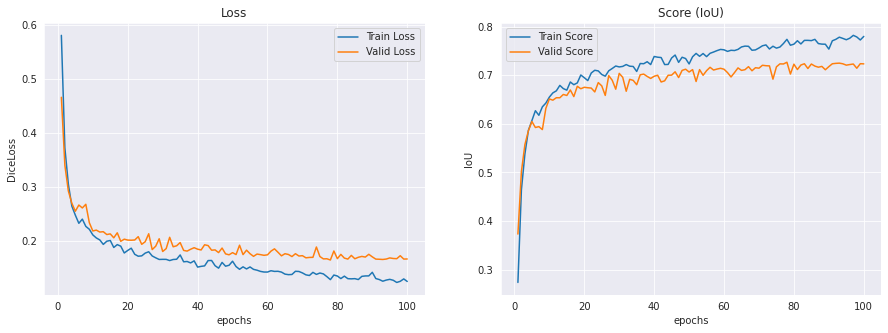

In [ ]:
import seaborn as sns

plt.figure(1)
plt.figure(figsize=(15,5))
sns.set_style(style="darkgrid")
plt.subplot(1, 2, 1)
sns.lineplot(x=range(1,101), y=total_train_loss, label="Train Loss")
sns.lineplot(x=range(1,101), y=total_valid_loss, label="Valid Loss")
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("DiceLoss")

plt.subplot(1, 2, 2)
sns.lineplot(x=range(1,101), y=total_train_score, label="Train Score")
sns.lineplot(x=range(1,101), y=total_valid_score, label="Valid Score")
plt.title("Score (IoU)")
plt.xlabel("epochs")
plt.ylabel("IoU")
plt.show()

In [ ]:
#loading the saved model
model, optimizer, start_epoch, valid_loss_min = load_ckp(checkpoint_path, model, optimizer)

In [ ]:
def visualize_predict(model, n_images):
  #model = model.eval()
  figure, ax = plt.subplots(nrows=n_images, ncols=3, figsize=(15, 18))
  with torch.no_grad():
    for data,mask in val_loader:
        data = torch.autograd.Variable(data, volatile=True).cuda()
        mask = torch.autograd.Variable(mask, volatile=True).cuda()
        o = model(data)
        break
  for img_no in range(0, n_images):
    tm=o[img_no][0].data.cpu().numpy()
    img = data[img_no].data.cpu()
    msk = mask[img_no].data.cpu()
    img = format_image(img)
    msk = format_mask(msk)
    ax[img_no, 0].imshow(img)
    ax[img_no, 1].imshow(msk, interpolation="nearest", cmap="gray")
    ax[img_no, 2].imshow(tm, interpolation="nearest", cmap="gray")
    ax[img_no, 0].set_title("Ground Truth Image")
    ax[img_no, 1].set_title("Ground Truth Mask")
    ax[img_no, 2].set_title("Predicted Mask")
    ax[img_no, 0].set_axis_off()
    ax[img_no, 1].set_axis_off()
    ax[img_no, 2].set_axis_off()
  plt.tight_layout()
  plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


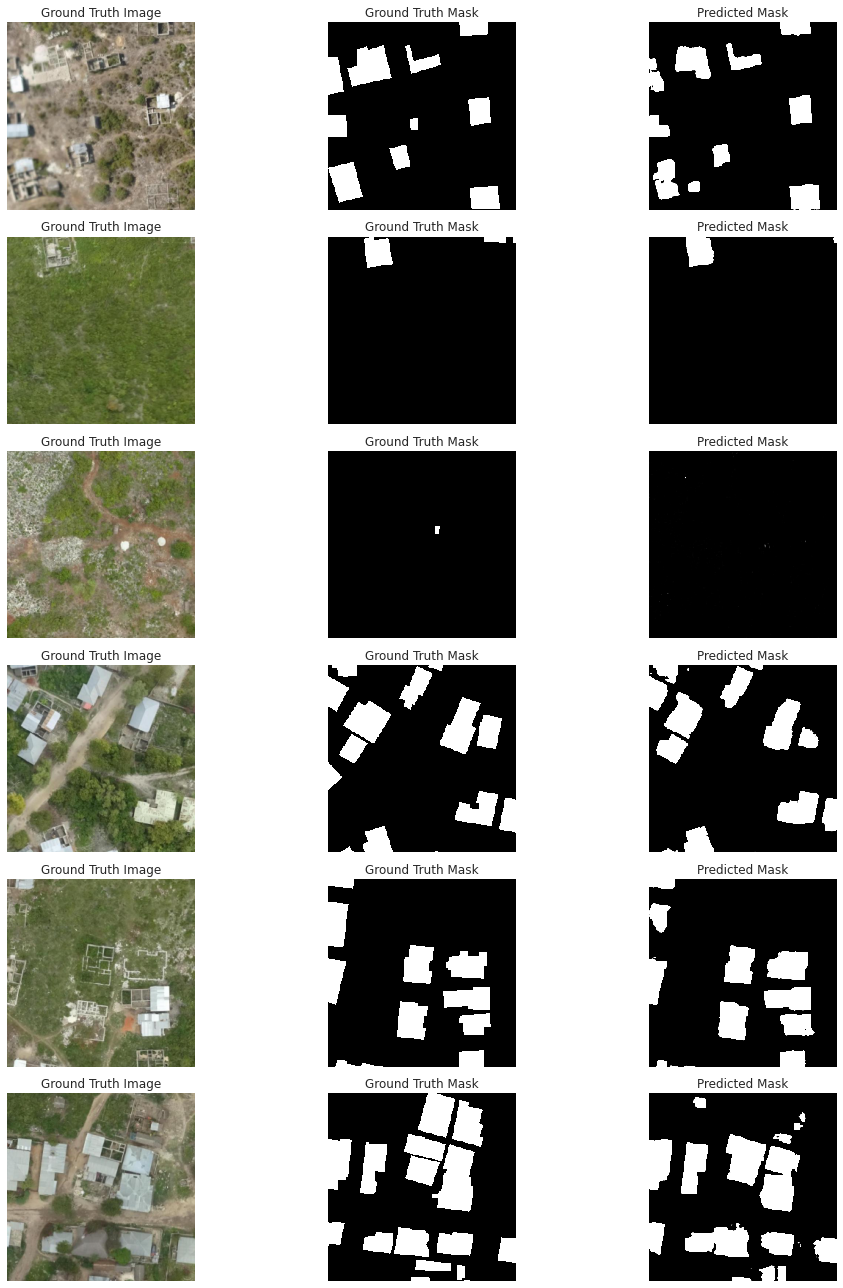

In [ ]:
visualize_predict(model, 6)